In [1]:
!pip install -U pandas matplotlib seaborn bs4 selenium tqdm

import time
import os
from collections import defaultdict

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from selenium import webdriver
from tqdm import tqdm

     |████████████████████████████████| 11.0 MB 985 kB/s eta 0:00:01
     |████████████████████████████████| 7.3 MB 3.2 MB/s eta 0:00:01
     |████████████████████████████████| 292 kB 37.7 MB/s eta 0:00:01
Processing /Users/saneryee/Library/Caches/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472/bs4-0.0.1-cp37-none-any.whl
     |████████████████████████████████| 983 kB 49.7 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 2.8 MB/s eta 0:00:011
     |████████████████████████████████| 930 kB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 128 kB 51.1 MB/s eta 0:00:01
     |████████████████████████████████| 138 kB 3.9 MB/s eta 0:00:01
     |████████████████████████████████| 358 kB 3.5 MB/s eta 0:00:01
  Using cached async_generator-1.10-py3-none-any.whl (18 kB)
     |████████████████████████████████| 58 kB 1.6 MB/s eta 0:00:01
  Attempting uninstall: pandas
    Found existing installation: pandas 1.0.3
    Uninstalling pandas-1.0.3:
      S

In [2]:
# Author object
class Author:
    def __init__(self, name, affil):
        self.name = name
        self.affil = affil
        self.num_total = 0
        self.num_accept = 0
        self.num_reject = 0
        self.scores = []
        self.scores_accept = []
        self.first_author = 0
        self.last_author = 0

    def update(self, authors_list, score, is_accepted):
        self.num_total += 1
        self.scores.append(score)

        if is_accepted:
            self.num_accept += 1
            self.scores_accept.append(score)
        else:
            self.num_reject += 1

        if self.name == authors_list[0]:
            self.first_author += 1
        elif self.name == authors_list[-1]:
            # elif to only increment solo author's first authorship, not senior
            self.last_author += 1

In [3]:
# Affiliation (Institution) object
class Affiliation:
    def __init__(self, name):
        self.name = name
        self.num_total = 0
        self.num_accept = 0
        self.num_reject = 0
        self.scores = []
        self.scores_accept = []

    def update(self, score, is_accepted):
        self.num_total += 1
        self.scores.append(score)

        if is_accepted:
            self.num_accept += 1
            self.scores_accept.append(score)
        else:
            self.num_reject += 1

In [5]:
# If haven't downloaded csvs, do so
author_csv_path = 'authors_iclr2021.csv'
affil_csv_path = 'affiliations_iclr2021.csv'

if not os.path.exists(author_csv_path) or not os.path.exists(affil_csv_path):
    # Start selenium
    options = webdriver.FirefoxOptions()
    options.headless = True
    driver = webdriver.Firefox(options=options)

    # Downloaded csv at https://docs.google.com/spreadsheets/d/1n58O0lgGI5kI0QQY9f4BDDpNB4oFjb5D51yMr9fHAK4/edit#gid=1546418007
    csv_path = 'iclr2021_results_final.csv'
    df = pd.read_csv(csv_path)

    # Init dict records
    authors_dict = {}
    affils_dict = defaultdict(int)

    # Go through each paper
    for _, paper in tqdm(df.iterrows(), total=df.shape[0]):
        # Paper info
        url, score, is_accepted = paper['url'], paper['avg_rating'], 'Accept' in paper['final_decision']

        # Nav to paper on openreview
        driver.get(url)
        html = driver.page_source
        soup = BeautifulSoup(html, 'html.parser')

        # Authors info
        author_hrefs = [x['href'] for x in soup.find_all("a", {'data-placement': 'top'})]
        author_names = [x.text for x in soup.find_all("a", {'data-placement': 'top'})]
        base_url = 'https://openreview.net'

        # Go through each author in paper
        this_paper_affils = []
        for author_href, author_name in zip(author_hrefs, author_names):
            author_url = base_url + author_href
            driver.get(author_url)
            author_html = driver.page_source
            author_soup = BeautifulSoup(author_html, 'html.parser')

            author_id = author_href.replace('/profile?id=', '')

            try:
                author_affil = author_soup.find('div', class_='title-container').h3.contents[0]
            except:
                author_affil = None

            # Record author
            if author_id not in authors_dict:
                authors_dict[author_id] = Author(author_name, author_affil)
            authors_dict[author_id].update(author_names, score, is_accepted)

            # Record affiliation, once per paper
            if author_affil not in this_paper_affils and author_affil is not None:
                if author_affil not in affils_dict:
                    affils_dict[author_affil] = Affiliation(author_affil)
                else:
                    affils_dict[author_affil].update(score, is_accepted)

    author_out_rows = [[a.name, 
                        a.affil, 
                        a.num_total, 
                        a.num_accept, 
                        a.num_reject, 
                        (sum(a.scores) / float(len(a.scores))) if len(a.scores) > 0 else 0,
                        (sum(a.scores_accept) / float(len(a.scores_accept))) if len(a.scores_accept) > 0 else 0,
                        a.first_author,
                        a.last_author
                        ] for a in authors_dict.values()]
    author_df = pd.DataFrame(author_out_rows, columns=['Name',
                                                       'Affiliation',
                                                       'Submitted',
                                                       'Accepted',
                                                       'Rejected',
                                                       'AvgScore',
                                                       'AvgAcceptedScore',
                                                       'FirstAuthorCount',
                                                       'LastAuthorCount'
                                                       ])
    print(author_df)
    author_accepted_df = author_df.sort_values('Accepted', ascending=False)
    author_first_author_df = author_df.sort_values('FirstAuthorCount', ascending=False)
    author_last_author_df = author_df.sort_values('LastAuthorCount', ascending=False)

    author_accepted_df.to_csv('authors_iclr2021.csv', index=False)
    author_first_author_df.to_csv('authors_first_iclr2021.csv', index=False)
    author_last_author_df.to_csv('authors_last_iclr2021.csv', index=False)
    print(f'Saved to author info to csvs')

    affil_out_rows = [[a.name, 
                       a.num_total, 
                       a.num_accept, 
                       a.num_reject, 
                       (sum(a.scores) / float(len(a.scores))) if len(a.scores) > 0 else 0,
                       (sum(a.scores_accept) / float(len(a.scores_accept))) if len(a.scores_accept) > 0 else 0,
                       ] for a in affils_dict.values()]
    affil_df = pd.DataFrame(affil_out_rows, columns=['Name',
                                                     'Submitted',
                                                     'Accepted',
                                                     'Rejected',
                                                     'AvgScore',
                                                     'AvgAcceptedScore',
                                                     ])
    print(affil_df)
    affil_accepted_df = affil_df.sort_values('Accepted', ascending=False)
    affil_avgacceptedscore_df = affil_df.sort_values('AvgAcceptedScore', ascending=False)
    affil_avgscore_df = affil_df.sort_values('AvgScore', ascending=False)

    affil_accepted_df.to_csv('affiliations_iclr2021.csv', index=False)
    affil_avgacceptedscore_df.to_csv('affiliations_avgacceptedscore_iclr2021.csv', index=False)
    affil_avgscore_df.to_csv('affiliations_avgscore_iclr2021.csv', index=False)

    print(f'Saved to affil info to csvs')

else:
    # Open saved author info
    author_df = pd.read_csv(author_csv_path)

    print(author_df)

    author_accepted_df = author_df.sort_values('Accepted', ascending=False)
    author_first_author_df = author_df.sort_values('FirstAuthorCount', ascending=False)
    author_last_author_df = author_df.sort_values('LastAuthorCount', ascending=False)

    # Open saved affiliation info
    affil_df = pd.read_csv(affil_csv_path)

    affil_accepted_df = affil_df.sort_values('Accepted', ascending=False)
    affil_avgacceptedscore_df = affil_df.sort_values('AvgAcceptedScore', ascending=False)
    affil_avgscore_df = affil_df.sort_values('AvgScore', ascending=False)

    print(affil_df)

                        Name  \
0                  Keyulu Xu   
1                Mozhi Zhang   
2                Jingling Li   
3           Simon Shaolei Du   
4     Ken-Ichi Kawarabayashi   
...                      ...   
8013       Anwitha Paruchuri   
8014                 Yan Cui   
8015                 Xi Chen   
8016            Haimin ZHANG   
8017                  Le Niu   

                                            Affiliation  Submitted  Accepted  \
0                 Massachusetts Institute of Technology          1         1   
1                  University of Maryland, College Park          1         1   
2     Department of Computer Science, University of ...          1         1   
3                              University of Washington          6         5   
4                                                   NaN          1         1   
...                                                 ...        ...       ...   
8013                                 Cornell University

/Users/saneryee/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Top 20 Authors at ICLR 2021')

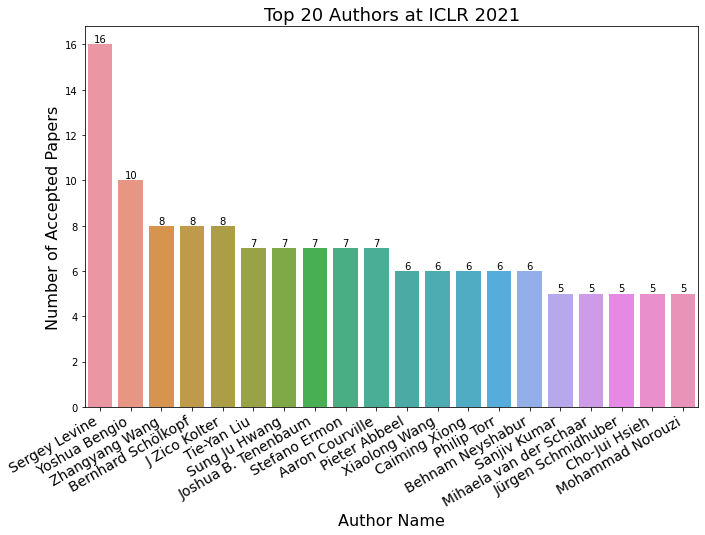

In [17]:
# Top 20 Most Accepted Authors - acceptances only
fig, author_accepted_plt = plt.subplots(figsize = (11,7))
author_accepted_plt = sns.barplot('Name', 'Accepted', data=author_accepted_df.head(n=20))
author_accepted_plt.set_xticklabels(author_accepted_plt.get_xticklabels(), rotation=30, ha='right', fontsize=14)
author_accepted_plt.bar_label(author_accepted_plt.containers[0])
author_accepted_plt.set_xlabel('Author Name', fontsize=16)
author_accepted_plt.set_ylabel('Number of Accepted Papers', fontsize=16)
author_accepted_plt.set_title('Top 20 Authors at ICLR 2021', fontsize=18)


Text(0.5, 1.0, 'Top 20 Authors at ICLR 2021 - Most Acceptances')

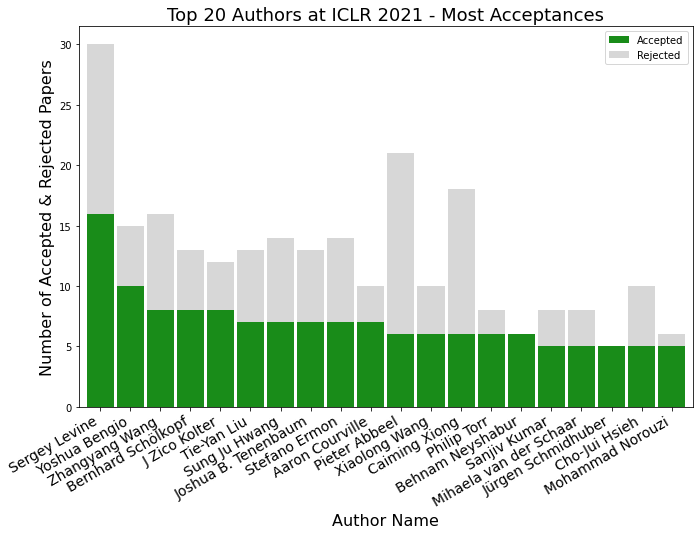

In [7]:
# Top 20 Most Accepted Authors - incl. their rejections
author_accepted_plt = author_accepted_df.head(n=20).plot.bar(x='Name', 
                                                             y=['Accepted', 'Rejected'], 
                                                             stacked=True, 
                                                             figsize=(11,7), 
                                                             alpha=.9,
                                                             color=['green','lightgray'], 
                                                             width=.9)
author_accepted_plt.set_xticklabels(author_accepted_df.head(n=20)['Name'], 
                                    rotation=30, 
                                    ha='right', 
                                    fontsize=14)
author_accepted_plt.set_xlabel('Author Name', fontsize=16)
author_accepted_plt.set_ylabel('Number of Accepted & Rejected Papers', fontsize=16)
author_accepted_plt.set_title('Top 20 Authors at ICLR 2021 - Most Acceptances', fontsize=18)

/Users/saneryee/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Top 20 Institutions at ICLR 2021')

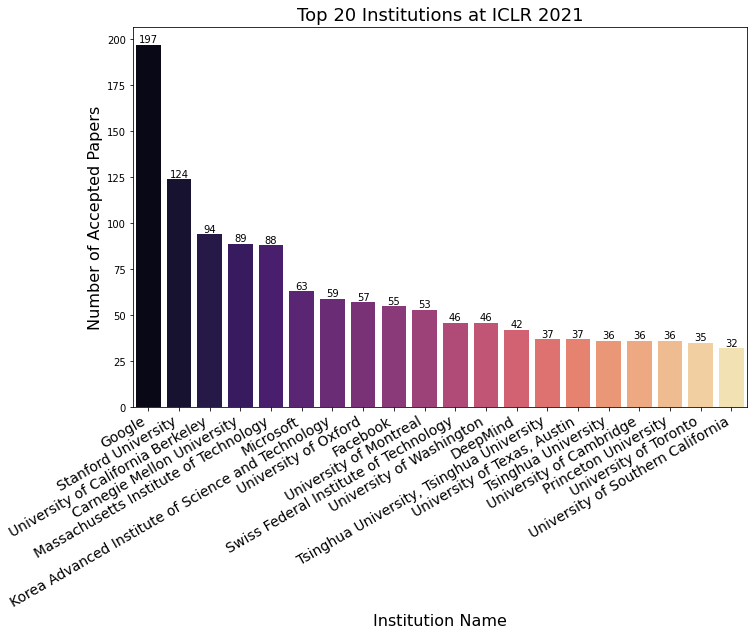

In [18]:
# Top 20 Most Accepted Institutions - acceptances only
fig, author_accepted_plt = plt.subplots(figsize = (11,7))
affil_accepted_plt = sns.barplot('Name', 'Accepted', data=affil_accepted_df.head(n=20), palette='magma')
affil_accepted_plt.set_xticklabels(affil_accepted_plt.get_xticklabels(), rotation=30, ha='right', fontsize=14)
affil_accepted_plt.bar_label(affil_accepted_plt.containers[0])
affil_accepted_plt.set_xlabel('Institution Name', fontsize=16)
affil_accepted_plt.set_ylabel('Number of Accepted Papers', fontsize=16)
affil_accepted_plt.set_title('Top 20 Institutions at ICLR 2021', fontsize=18)

Text(0.5, 1.0, 'Top 20 Institutions at ICLR 2021 - Most Acceptances')

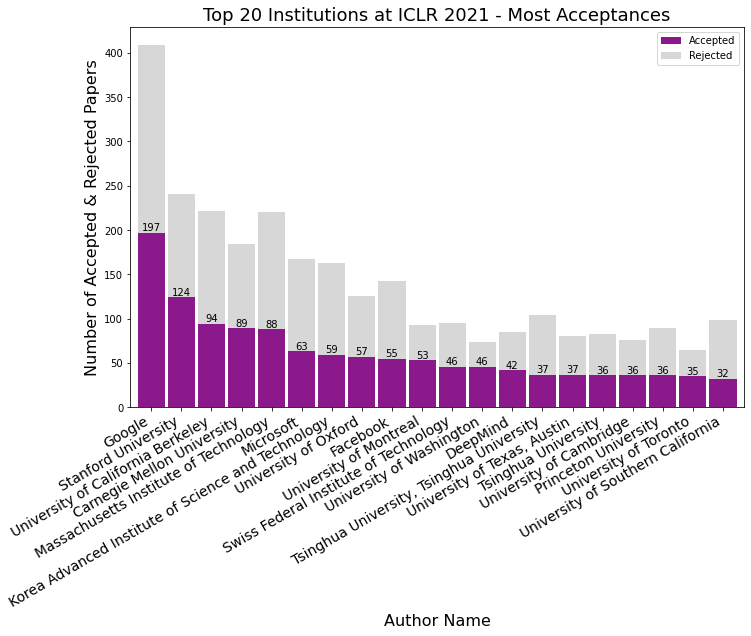

In [19]:
# Top 20 Most Accepted Institutions - incl. their rejections
affil_accepted_plt = affil_accepted_df.head(n=20).plot.bar(x='Name', 
                                                           y=['Accepted', 'Rejected'], 
                                                           stacked=True, 
                                                           figsize=(11,7), 
                                                           alpha=.9,
                                                           color=['purple','lightgray'], 
                                                           width=.9)
affil_accepted_plt.set_xticklabels(affil_accepted_df.head(n=20)['Name'], 
                                   rotation=30, 
                                   ha='right', 
                                   fontsize=14)
affil_accepted_plt.bar_label(affil_accepted_plt.containers[0])
affil_accepted_plt.set_xlabel('Author Name', fontsize=16)
affil_accepted_plt.set_ylabel('Number of Accepted & Rejected Papers', fontsize=16)
affil_accepted_plt.set_title('Top 20 Institutions at ICLR 2021 - Most Acceptances', fontsize=18)

/Users/saneryee/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Top 20 1st Authors at ICLR 2021')

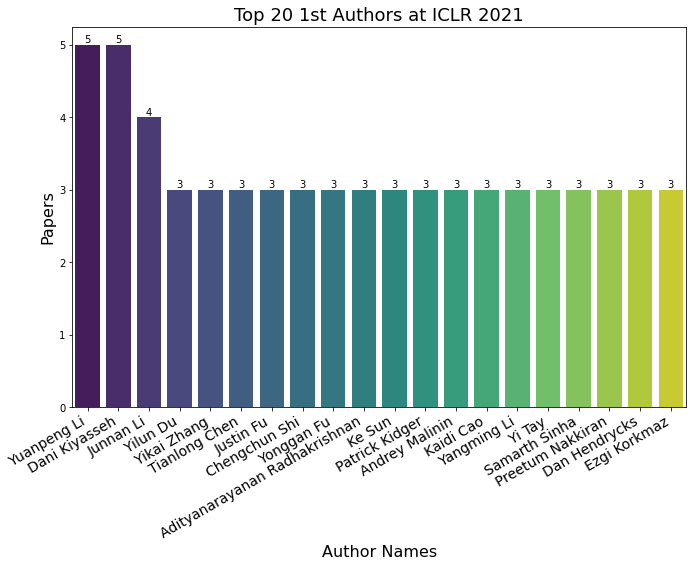

In [20]:
# Top 20 First Authors
fig, author_first_plt = plt.subplots(figsize = (11,7))
author_first_plt = sns.barplot('Name', 'FirstAuthorCount', data=author_first_author_df.head(n=20), palette='viridis')
author_first_plt.set_xticklabels(author_first_plt.get_xticklabels(), rotation=30, ha='right', fontsize=14)
author_first_plt.bar_label(author_first_plt.containers[0])
author_first_plt.set_xlabel('Author Names', fontsize=16)
author_first_plt.set_ylabel('Papers', fontsize=16)
author_first_plt.set_title('Top 20 1st Authors at ICLR 2021', fontsize=18)

/Users/saneryee/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


([<matplotlib.axis.YTick at 0x7feb72e9bd68>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

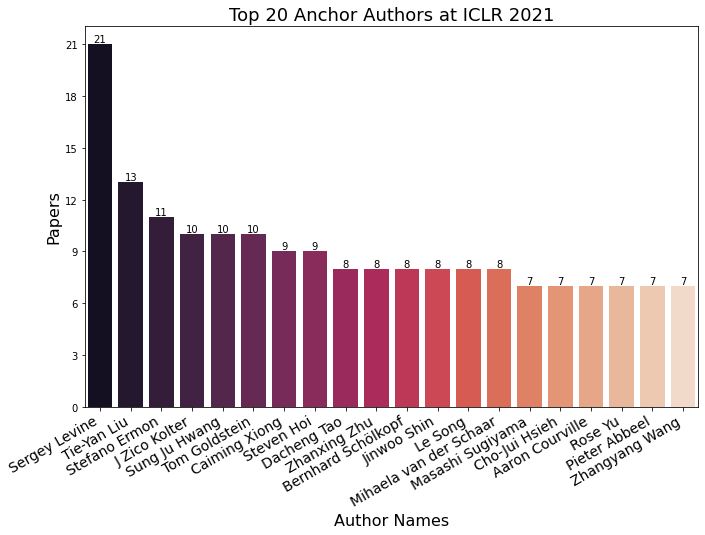

In [23]:
# Top 20 Last Authors
fig, author_last_plt = plt.subplots(figsize = (11,7))
author_last_plt = sns.barplot('Name', 'LastAuthorCount', data=author_last_author_df.head(n=20), palette='rocket')
author_last_plt.bar_label(author_last_plt.containers[0])
author_last_plt.set_xticklabels(author_last_plt.get_xticklabels(), rotation=30, ha='right', fontsize=14)
author_last_plt.set_xlabel('Author Names', fontsize=16)
author_last_plt.set_ylabel('Papers', fontsize=16)
author_last_plt.set_title('Top 20 Anchor Authors at ICLR 2021', fontsize=18)
yint = list(range(0, 22, 3))
plt.yticks(yint)

/Users/saneryee/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Top 20 Institutions at ICLR 2021 by Average Score')

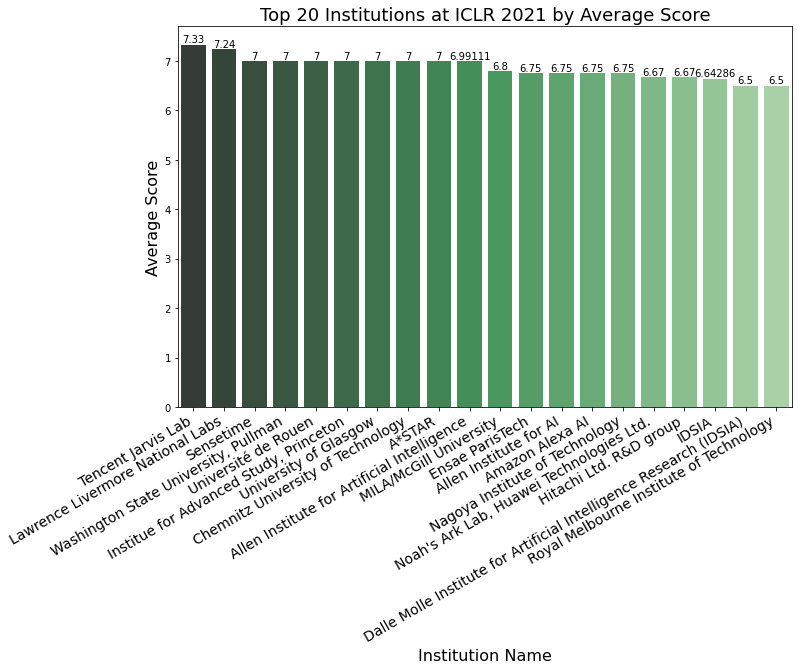

In [24]:
# Top 20 Highest Scoring Institutions - overall
fig, affil_avgscore_plt = plt.subplots(figsize = (11,7))
sns.set_palette(reversed(sns.color_palette("Greens_d", 20)), 20)
affil_avgscore_plt = sns.barplot('Name', 'AvgScore', data=affil_avgscore_df.head(n=20))
affil_avgscore_plt.set_xticklabels(affil_avgscore_plt.get_xticklabels(), rotation=30, ha='right', fontsize=14)
affil_avgscore_plt.bar_label(affil_avgscore_plt.containers[0])
affil_avgscore_plt.set_xlabel('Institution Name', fontsize=16)
affil_avgscore_plt.set_ylabel('Average Score', fontsize=16)
affil_avgscore_plt.set_title('Top 20 Institutions at ICLR 2021 by Average Score', fontsize=18)

In [ ]:
# Quick shortening of long name for Berkeley
affil_avgacceptedscore_df = affil_avgacceptedscore_df.reset_index()
affil_avgacceptedscore_df.at[4, 'Name'] = affil_avgacceptedscore_df.iloc[4]['Name'].replace('Electrical Engineering & Computer Science Department, ', '')

/Users/saneryee/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Top 20 Institutions at ICLR 2021 - by Average Accepted Score')

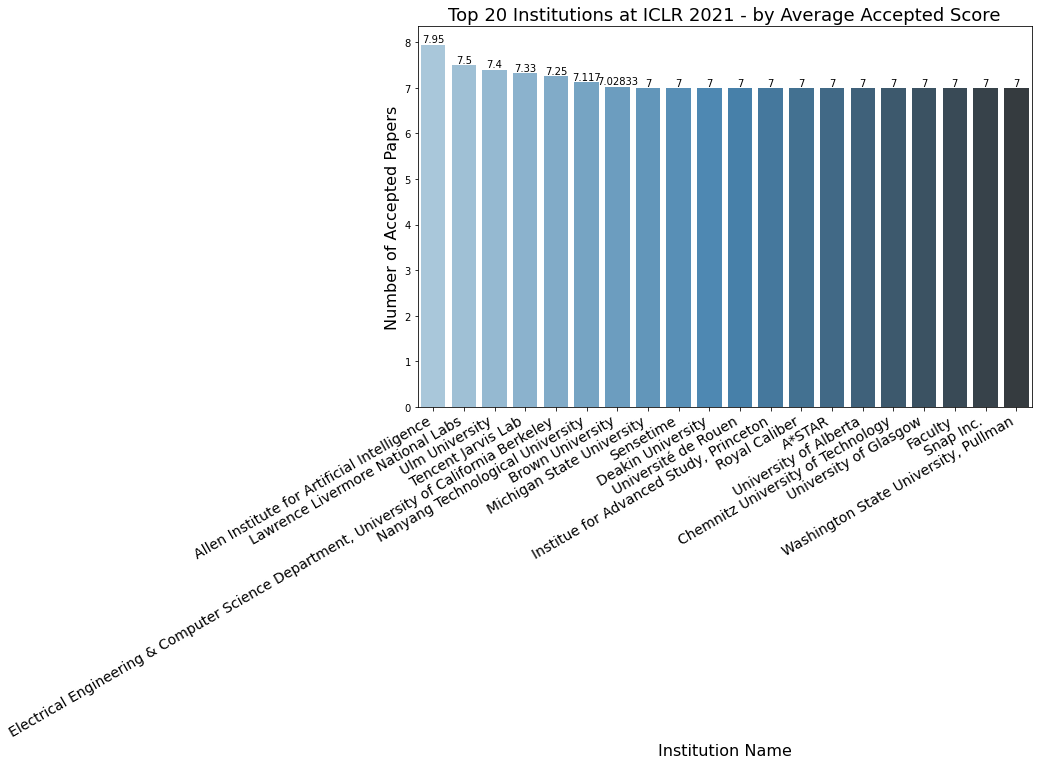

In [25]:
# Top 20 Highest Scoring Institutions - acceptances only
fig, affil_avgacceptedscore_plt = plt.subplots(figsize = (11,7))
sns.set_palette(sns.color_palette("Blues_d", 20), 20)
affil_avgacceptedscore_plt = sns.barplot('Name', 'AvgAcceptedScore', data=affil_avgacceptedscore_df.head(n=20))
affil_avgacceptedscore_plt.bar_label(affil_avgacceptedscore_plt.containers[0])
affil_avgacceptedscore_plt.set_xticklabels(affil_avgacceptedscore_plt.get_xticklabels(), rotation=30, ha='right', fontsize=14)
affil_avgacceptedscore_plt.set_xlabel('Institution Name', fontsize=16)
affil_avgacceptedscore_plt.set_ylabel('Number of Accepted Papers', fontsize=16)
affil_avgacceptedscore_plt.set_title('Top 20 Institutions at ICLR 2021 - by Average Accepted Score', fontsize=18)

In [188]:
# That's a wrap! Hope you found this notebook useful, informative, and maybe even beautiful, thanks to seaborn.